<a href="https://colab.research.google.com/github/TheReallyBigApple/CunyAssignments/blob/main/Data604/chap09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                       CUNY MSDS Data604 Week 4
#                            Tom Buonora

# Chapter 9

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

     |████████████████████████████████| 215kB 23.5MB/s 
  Created wheel for modsimpy: filename=modsimpy-1.1.3-cp37-none-any.whl size=20356 sha256=a4abab56621f90c46b302609270801902df99e27856d8a37a9112fccfa5e67cd
  Stored in directory: /root/.cache/pip/wheels/59/34/ac/e82f103fbfb5d961b1a4d2b8e89bb6629a4c0b242e5373cbfa
Successfully built modsimpy


The following displays SymPy expressions and provides the option of showing results in LaTeX format.

In [2]:
from sympy.printing import latex

def show(expr, show_latex=False):
    """Display a SymPy expression.
    
    expr: SymPy expression
    show_latex: boolean
    """
    if show_latex:
        print(latex(expr))
    return expr

### Analysis with SymPy

Create a symbol for time.

In [3]:
import sympy as sp

t = sp.symbols('t')
t

t

If you combine symbols and numbers, you get symbolic expressions.

In [4]:
expr = t + 1
expr

t + 1

The result is an `Add` object, which just represents the sum without trying to compute it.

In [5]:
type(expr)

sympy.core.add.Add

`subs` can be used to replace a symbol with a number, which allows the addition to proceed.

In [6]:
expr.subs(t, 2)

3

`f` is a special class of symbol that represents a function.

In [7]:
f = sp.Function('f')
f

f

The type of `f` is `UndefinedFunction`

In [8]:
type(f)

sympy.core.function.UndefinedFunction

SymPy understands that `f(t)` means `f` evaluated at `t`, but it doesn't try to evaluate it yet.

In [9]:
f(t)

f(t)

`diff` returns a `Derivative` object that represents the time derivative of `f`

In [10]:
dfdt = sp.diff(f(t), t)
dfdt

Derivative(f(t), t)

In [11]:
type(dfdt)

sympy.core.function.Derivative

We need a symbol for `alpha`

In [12]:
alpha = sp.symbols('alpha')
alpha

alpha

Now we can write the differential equation for proportional growth.

In [13]:
eq1 = sp.Eq(dfdt, alpha*f(t))
eq1

Eq(Derivative(f(t), t), alpha*f(t))

And use `dsolve` to solve it.  The result is the general solution.

In [14]:
solution_eq = sp.dsolve(eq1)
solution_eq

Eq(f(t), C1*exp(alpha*t))

We can tell it's a general solution because it contains an unspecified constant, `C1`.

In this example, finding the particular solution is easy: we just replace `C1` with `p_0`

In [15]:
C1, p_0 = sp.symbols('C1 p_0')

In [16]:
particular = solution_eq.subs(C1, p_0)
particular

Eq(f(t), p_0*exp(alpha*t))

In the next example, we have to work a little harder to find the particular solution.

### Solving the quadratic growth equation 

We'll use the (r, K) parameterization, so we'll need two more symbols:

In [17]:
r, K = sp.symbols('r K')

Now we can write the differential equation.

In [18]:
eq2 = sp.Eq(sp.diff(f(t), t), r * f(t) * (1 - f(t)/K))
eq2

Eq(Derivative(f(t), t), r*(1 - f(t)/K)*f(t))

And solve it.

In [19]:
solution_eq = sp.dsolve(eq2)
solution_eq

Eq(f(t), K*exp(C1*K + r*t)/(exp(C1*K + r*t) - 1))

The result, `solution_eq`, contains `rhs`, which is the right-hand side of the solution.

In [20]:
general = solution_eq.rhs
general

K*exp(C1*K + r*t)/(exp(C1*K + r*t) - 1)

We can evaluate the right-hand side at $t=0$

In [21]:
at_0 = general.subs(t, 0)
at_0

K*exp(C1*K)/(exp(C1*K) - 1)

Now we want to find the value of `C1` that makes `f(0) = p_0`.

So we'll create the equation `at_0 = p_0` and solve for `C1`.  Because this is just an algebraic identity, not a differential equation, we use `solve`, not `dsolve`.

The result from `solve` is a list of solutions.  In this case, [we have reason to expect only one solution](https://en.wikipedia.org/wiki/Picard%E2%80%93Lindel%C3%B6f_theorem), but we still get a list, so we have to use the bracket operator, `[0]`, to select the first one.

In [22]:
solutions = sp.solve(sp.Eq(at_0, p_0), C1)
type(solutions), len(solutions)

(list, 1)

In [23]:
value_of_C1 = solutions[0]
value_of_C1

log(-p_0/(K - p_0))/K

Now in the general solution, we want to replace `C1` with the value of `C1` we just figured out.

In [24]:
particular = general.subs(C1, value_of_C1)
particular

-K*p_0*exp(r*t)/((K - p_0)*(-p_0*exp(r*t)/(K - p_0) - 1))

The result is complicated, but SymPy provides a method that tries to simplify it.

In [25]:
particular = sp.simplify(particular)
particular

K*p_0*exp(r*t)/(K + p_0*exp(r*t) - p_0)

Often simplicity is in the eye of the beholder, but that's about as simple as this expression gets.

Just to double-check, we can evaluate it at `t=0` and confirm that we get `p_0`

In [26]:
particular.subs(t, 0)

p_0

This solution is called the [logistic function](https://en.wikipedia.org/wiki/Population_growth#Logistic_equation).

In some places you'll see it written in a different form:

$f(t) = \frac{K}{1 + A e^{-rt}}$

where $A = (K - p_0) / p_0$.

We can use SymPy to confirm that these two forms are equivalent.  First we represent the alternative version of the logistic function:

In [27]:
A = (K - p_0) / p_0
A

(K - p_0)/p_0

In [28]:
logistic = K / (1 + A * sp.exp(-r*t))
logistic

K/(1 + (K - p_0)*exp(-r*t)/p_0)

To see whether two expressions are equivalent, we can check whether their difference simplifies to 0.

In [29]:
sp.simplify(particular - logistic)

0

This test only works one way: if SymPy says the difference reduces to 0, the expressions are definitely equivalent (and not just numerically close).

But if SymPy can't find a way to simplify the result to 0, that doesn't necessarily mean there isn't one.  Testing whether two expressions are equivalent is a surprisingly hard problem; in fact, there is no algorithm that can solve it in general.

### Exercises

**Exercise:** Solve the quadratic growth equation using the alternative parameterization

$\frac{df(t)}{dt} = \alpha f(t) + \beta f^2(t) $

In [31]:
alpha, beta = sp.symbols('alpha beta')

In [33]:
# the Eq function returns an equality object 
#   that can be passed to other functions like dsolve
#  however if you pass it 2 solvable expressions, 
#      it will return True or False indicating if they are equal

# sp.diff returns an object of type sympy.core.function.Derivative
#      which also can be passed to other functions like Eq

eq3 = sp.Eq(sp.diff(f(t), t), alpha*f(t) + beta*f(t)**2)
eq3

Eq(Derivative(f(t), t), alpha*f(t) + beta*f(t)**2)

In [35]:
# dsolve returns the function, when you pass it the derivative
solution_eq = sp.dsolve(eq3)
solution_eq

Eq(f(t), alpha*exp(alpha*(C1 + t))/(beta*(1 - exp(alpha*(C1 + t)))))

In [36]:
# isolate the right hand side ( convert to a datatype we can use to sub 0 for t )
general = solution_eq.rhs
general

alpha*exp(alpha*(C1 + t))/(beta*(1 - exp(alpha*(C1 + t))))

In [37]:
# set t to 0
at_0 = general.subs(t, 0)

In [40]:
# note: p_0 and C1 are symbols, while at_0 is sympy.core.mul.Mul ( expression )
solutions = sp.solve(sp.Eq(at_0, p_0), C1)
value_of_C1 = solutions[0]
value_of_C1

log(beta*p_0/(alpha + beta*p_0))/alpha

In [41]:
# Now in the general solution, we want to replace C1 with the value of C1 we just figured out.
particular = general.subs(C1, value_of_C1)
particular.simplify()

alpha*p_0*exp(alpha*t)/(alpha - beta*p_0*exp(alpha*t) + beta*p_0)

**Exercise:**  Use [WolframAlpha](https://www.wolframalpha.com/) to solve the quadratic growth model, using either or both forms of parameterization:

    df(t) / dt = alpha f(t) + beta f(t)^2

or

    df(t) / dt = r f(t) (1 - f(t)/K)

Find the general solution and also the particular solution where `f(0) = p_0`.

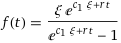